In [39]:
using Pkg
Pkg.activate("..")

using NCDatasets
using Dates
using CSV, DataFrames
using Statistics
using PyPlot


  Activating project at `~/Projects/cmip6`


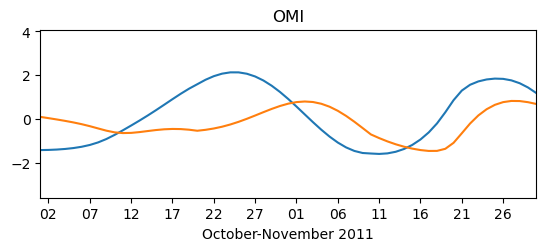

In [149]:
# omi kiladis et al. 2014
omi = CSV.read("./psl_mjoindex/omi.1x.txt", DataFrame, delim=" ", header=0, ignorerepeated=true)

omidt = Date.(omi[:,1], omi[:,2], omi[:,3])
omi1 = omi[:,5]
omi2 = omi[:,6]
omiampl = omi[:,7]
omiphs = atan.(omi2,omi1) # phase, of what convention?

std(omi2) # 0.907

function dt2mt(dt)
    if dt isa Date # value in days
        Dates.value(dt)
    elseif dt isa DateTime # value in milliseconds
        Dates.value(dt)/86400000
    end
end

clf()
ax1 = subplot(2,1,1)
ax1.plot(dt2mt.(omidt), omi1) # central Indian Oc convection
ax1.plot(dt2mt.(omidt), omi2)
ax1.set_xlim(dt2mt.([Date(2011,10,1), Date(2011,11,30)]))
# mpl date formatters
majorformatter = matplotlib[:dates][:DateFormatter]("%d")
#minorformatter = matplotlib[:dates][:DateFormatter]("%H:%M")
majorlocator = matplotlib[:dates][:DayLocator](interval=5)
#minorlocator = matplotlib[:dates][:HourLocator](byhour=(8, 16))
ax1[:xaxis][:set_major_formatter](majorformatter)
#ax1[:xaxis][:set_minor_formatter](minorformatter)
ax1[:xaxis][:set_major_locator](majorlocator)
#ax1[:xaxis][:set_minor_locator](minorlocator)
title("OMI")
xlabel("October-November 2011")
gcf()

In [153]:
# ERA5 temperature and specific_humidity
era = NCDataset("ERA5-bl-temperature-easteq.nc")
erat = era[:t][:,:,:,:]
eraq = NCDataset("ERA5-bl-shum-easteq.nc")[:q][:,:,:,:]

# vertical grid
L137_table = CSV.read("L137_table.csv", DataFrame,
    types=[Int64, Float64, Float64, Float64, Union{Missing,Float64}, Union{Missing,Float64}, Float64, Float64, Float64],
    missingstring="-")
galt = zeros(Float64, size(L137_table[119:end,1]))
galt .= L137_table[119:end,"Geometric Altitude [m]"][:]
pres = 0*galt
pres .= L137_table[119:end,"ph [hPa]"]

MethodError: MethodError: no method matching isless(::Int64, ::CommonDataModel.CFVariable{Float32, 1, NCDatasets.Variable{Float32, 1, NCDataset{Nothing}}, NCDatasets.Attributes{NCDataset{Nothing}}, NamedTuple{(:fillvalue, :missing_values, :scale_factor, :add_offset, :calendar, :time_origin, :time_factor), Tuple{Nothing, Tuple{}, Vararg{Nothing, 5}}}})

Closest candidates are:
  isless(!Matched::AbstractVector, ::AbstractVector)
   @ Base abstractarray.jl:2913
  isless(::Real, !Matched::AbstractFloat)
   @ Base operators.jl:178
  isless(::Real, !Matched::Real)
   @ Base operators.jl:421
  ...


In [168]:
# blh
blh = NCDataset("ERA5-bl-blh-easteq.nc")

blh[:time] # DateTime
i80 = findall(x-> 78<x<82, blh[:longitude][:])
jeq = findall(x-> -2<x<2 , blh[:latitude][:])
blh[:blh][i80,jeq,:] # lon,lat,time
mean(blh[:blh][i80,jeq,:], dims=(1,2))[:]
length(i80), length(jeq)


(15, 15)

In [193]:
[print("'$(y)',") for y in 1993:2022]
[ '01','02','03','04','05','06','07','08,'09','10','11','12']

'1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022',

ErrorException: syntax: character literal contains multiple characters

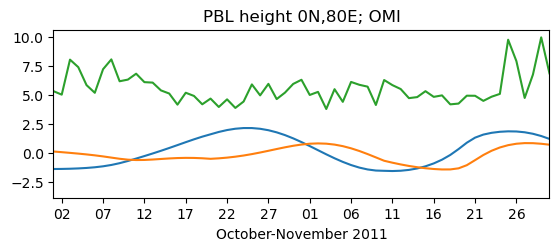

In [194]:
clf()
ax1 = subplot(2,1,1)
ax1.plot(dt2mt.(omidt), omi1) # central Indian Oc convection
ax1.plot(dt2mt.(omidt), omi2)
ax1.plot(dt2mt.(blh[:time]), mean(blh[:blh][i80,jeq,:], dims=(1,2))[:]/100)
ax1.set_xlim(dt2mt.([Date(2011,10,1), Date(2011,11,30)]))
# mpl date formatters
majorformatter = matplotlib[:dates][:DateFormatter]("%d")
majorlocator = matplotlib[:dates][:DayLocator](interval=5)
ax1[:xaxis][:set_major_formatter](majorformatter)
ax1[:xaxis][:set_major_locator](majorlocator)
title("PBL height 0N,80E; OMI")
xlabel("October-November 2011")
savefig("pblh_omi_dynamo2011.png")
gcf()

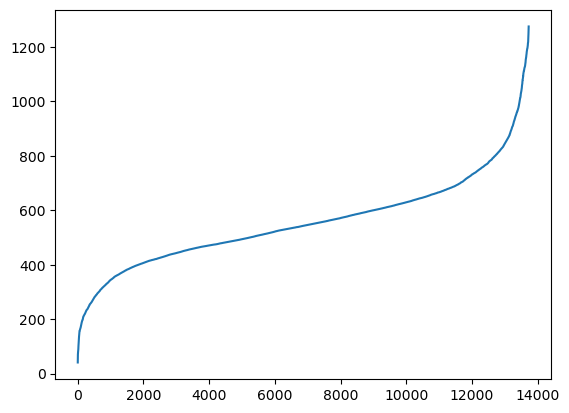

In [176]:
plotcdf(x; kwargs...) = plot((1:length(x))/length(x), sort(x); kwargs...) 

#cumulative distribution of BLH
clf()
# plot(sort(blh[:blh][i80,jeq,:][:]))
plotcdf(blh[:blh][i80,jeq,:][:])
ylabel("PBL height (m)")
title("equaltorial 80E PBLH cumulative distribution")
gcf()

In [180]:
theta(t,p) = t * (1e3/p)^0.287
# erath = broadcast(theta, erat, pres)
erath = zeros(size(erat))
# map along 3rd dimension, super slow!
for ci in CartesianIndices(erat) 
    erath[ci] = theta(erat[ci],pres[ci[3]])
end

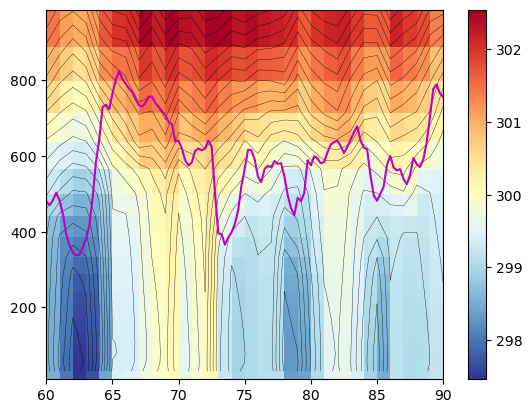

In [181]:
pd = permutedims
anom(x,dims) = x .- mean(x,dims)

clf()
pcolormesh(era[:longitude][61:91], galt[1:end], pd(erath[61:90,11,:,1]), 
    shading="flat", cmap=ColorMap("RdYlBu_r"))
colorbar()
contour(era[:longitude][61:91], galt[1:end-1], pd(erath[61:91,11,:,1]), 
    colors="k", linewidths=0.25, levels= 296.8:0.2:303.2)
plot(blh[:longitude][241:end], blh[:blh][241:end,41,1], color="m")
gcf()

In [188]:
blh[:time][1], blh[:time][end]

(DateTime("2011-10-01T00:00:00"), DateTime("2011-11-30T00:00:00"))